--- Feature Engineering ---
Kích thước tập huấn luyện X: (1548, 9), y: (1548,)
Kích thước tập kiểm tra X: (388, 9), y: (388,)

Sử dụng mô hình: Hồi quy với Đa thức(Time_Step, bậc=2) + Đặc trưng tuyến tính
Các features cuối cùng cho mô hình: ['Time_Step', 'Time_Step^2', 'Close_Lag1', 'Close_Lag3', 'Close_Lag7', 'Volume_Lag1', 'Open_Lag1', 'Close_Rolling_Mean7', 'Close_Rolling_Std7', 'Volume_Rolling_Mean7']

--- Đánh Giá Mô Hình ---
Tập Huấn Luyện:
  RMSE: 1119.27
  MAE:  512.17
  MAPE: 2.52%
  R-squared: 0.9949
Tập Kiểm Tra:
  RMSE: 2071.25
  MAE:  1478.32
  MAPE: 1.92%
  R-squared: 0.9830

Đã lưu biểu đồ bitcoin_regression_engineered_features_with_mape.png


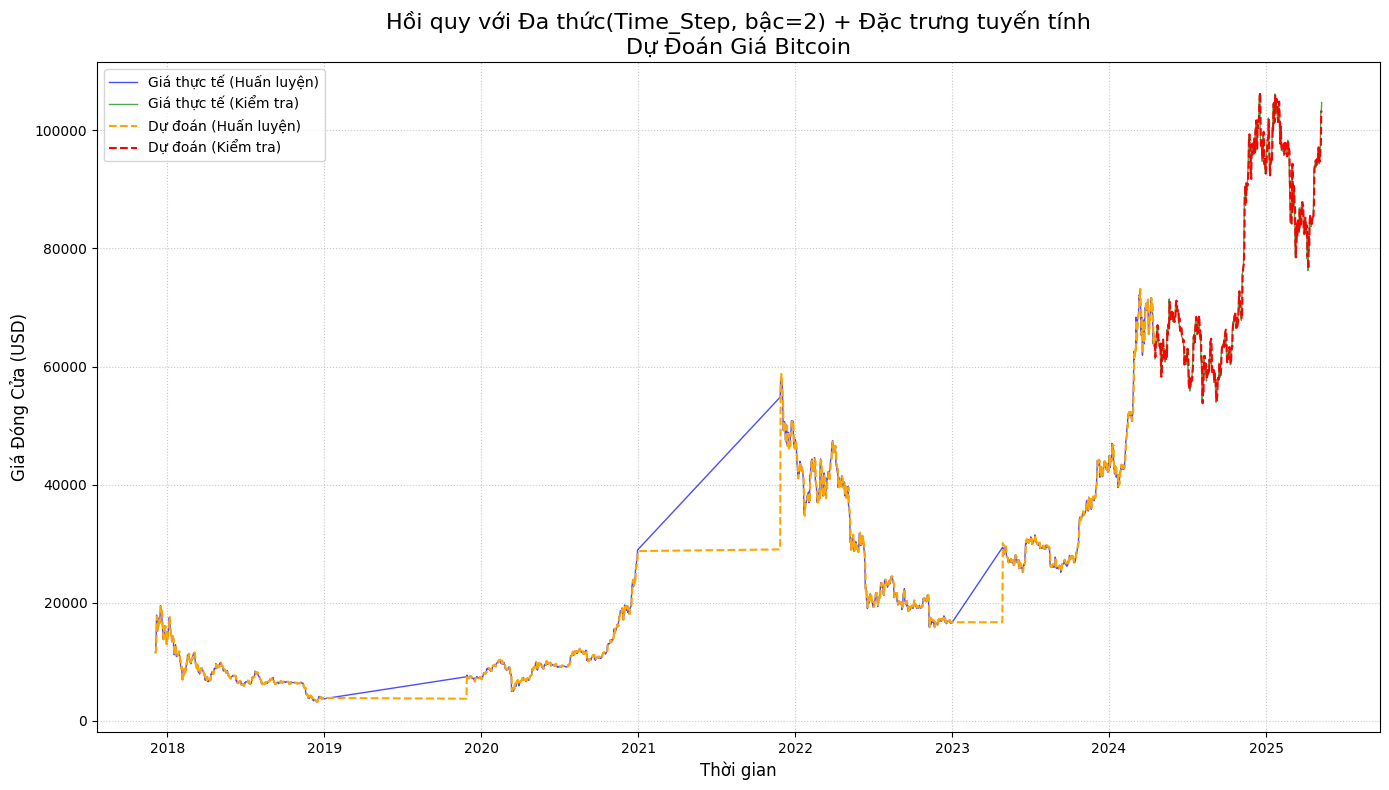

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- CÀI ĐẶT CHO HIỂN THỊ TIẾNG VIỆT TRÊN BIỂU ĐỒ (TÙY CHỌN) ---
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['axes.unicode_minus'] = False

# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Tránh chia cho 0 nếu y_true có giá trị 0
    # Bằng cách thay thế 0 bằng một số rất nhỏ (epsilon) hoặc loại bỏ các điểm đó
    # Ở đây, chúng ta sẽ loại bỏ các điểm có y_true = 0 để tránh lỗi
    mask = y_true != 0
    if not np.all(mask): # Nếu có giá trị 0 trong y_true
        print("Cảnh báo: Có giá trị 0 trong y_true. Các điểm này sẽ được bỏ qua khi tính MAPE.")
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


# 1. Load the data
try:
    df = pd.read_csv('/content/Bitcoin.csv', delimiter =';')
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file coin_Bitcoin.csv. Vui lòng đảm bảo file nằm trong cùng thư mục.")
    exit()

# 2. Preprocessing cơ bản
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# --- FEATURE ENGINEERING ---
print("--- Feature Engineering ---")
df['Time_Step'] = np.arange(len(df.index))

df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag3'] = df['Close'].shift(3)
df['Close_Lag7'] = df['Close'].shift(7)

df['Volume_Lag1'] = df['Volume'].shift(1)
df['Open_Lag1'] = df['Open'].shift(1)

df['Close_Rolling_Mean7'] = df['Close'].rolling(window=7).mean().shift(1)
df['Close_Rolling_Std7'] = df['Close'].rolling(window=7).std().shift(1)
df['Volume_Rolling_Mean7'] = df['Volume'].rolling(window=7).mean().shift(1)

df.dropna(inplace=True)

if df.empty:
    print("Lỗi: DataFrame trống sau khi loại bỏ NaN. Có thể do không đủ dữ liệu cho các cửa sổ trễ/trượt.")
    exit()

y = df['Close']
features_for_model = [
    'Time_Step',
    'Close_Lag1',
    'Close_Lag3',
    'Close_Lag7',
    'Volume_Lag1',
    'Open_Lag1',
    'Close_Rolling_Mean7',
    'Close_Rolling_Std7',
    'Volume_Rolling_Mean7'
]
X_base = df[features_for_model]

# 3. Train-Test Split
X_train_base, X_test_base, y_train, y_test = train_test_split(X_base, y, test_size=0.2, shuffle=False)

print(f"Kích thước tập huấn luyện X: {X_train_base.shape}, y: {y_train.shape}")
print(f"Kích thước tập kiểm tra X: {X_test_base.shape}, y: {y_test.shape}")

# 4. Feature Transformation and Scaling
poly_degree_time = 2
use_poly_on_time_only = True # Đặt thành True hoặc False để thử nghiệm
model_description = f"Hồi quy với Đa thức(Time_Step, bậc={poly_degree_time}) + Đặc trưng tuyến tính"

if use_poly_on_time_only:
    poly_transformer_time = PolynomialFeatures(degree=poly_degree_time, include_bias=False)
    X_train_time_poly = poly_transformer_time.fit_transform(X_train_base[['Time_Step']])
    X_test_time_poly = poly_transformer_time.transform(X_test_base[['Time_Step']])
    poly_time_feature_names = poly_transformer_time.get_feature_names_out(['Time_Step'])
    X_train_poly_time_df = pd.DataFrame(X_train_time_poly, columns=poly_time_feature_names, index=X_train_base.index)
    X_test_poly_time_df = pd.DataFrame(X_test_time_poly, columns=poly_time_feature_names, index=X_test_base.index)
    other_features_train = X_train_base.drop(columns=['Time_Step'])
    other_features_test = X_test_base.drop(columns=['Time_Step'])
    X_train_processed = pd.concat([X_train_poly_time_df, other_features_train], axis=1)
    X_test_processed = pd.concat([X_test_poly_time_df, other_features_test], axis=1)
else:
    X_train_processed = X_train_base
    X_test_processed = X_test_base
    model_description = "Hồi quy tuyến tính với các đặc trưng được tạo"

print(f"\nSử dụng mô hình: {model_description}")
print(f"Các features cuối cùng cho mô hình: {X_train_processed.columns.tolist()}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

# 5. Model Training
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 6. Prediction
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# 7. Evaluation
print("\n--- Đánh Giá Mô Hình ---")
# Training set
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"Tập Huấn Luyện:")
print(f"  RMSE: {rmse_train:.2f}")
print(f"  MAE:  {mae_train:.2f}")
print(f"  MAPE: {mape_train:.2f}%")
print(f"  R-squared: {r2_train:.4f}")

# Test set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Tập Kiểm Tra:")
print(f"  RMSE: {rmse_test:.2f}")
print(f"  MAE:  {mae_test:.2f}")
print(f"  MAPE: {mape_test:.2f}%")
print(f"  R-squared: {r2_test:.4f}")

# --- 8. TRỰC QUAN HÓA KẾT QUẢ ---
plt.figure(figsize=(14, 8))
plt.plot(y_train.index, y_train, label='Giá thực tế (Huấn luyện)', color='blue', alpha=0.7, linewidth=1)
plt.plot(y_test.index, y_test, label='Giá thực tế (Kiểm tra)', color='green', alpha=0.7, linewidth=1)

y_pred_train_series = pd.Series(y_pred_train, index=y_train.index)
y_pred_test_series = pd.Series(y_pred_test, index=y_test.index)

plt.plot(y_pred_train_series.index, y_pred_train_series, label=f'Dự đoán (Huấn luyện)', color='orange', linestyle='--', linewidth=1.5)
plt.plot(y_pred_test_series.index, y_pred_test_series, label=f'Dự đoán (Kiểm tra)', color='red', linestyle='--', linewidth=1.5)

plt.title(f'{model_description}\nDự Đoán Giá Bitcoin', fontsize=16)
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Giá Đóng Cửa (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.savefig(f'bitcoin_regression_engineered_features_with_mape.png')
print(f"\nĐã lưu biểu đồ bitcoin_regression_engineered_features_with_mape.png")
# plt.show()

